In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import simpy
from LEOEnvironmentRL import initialize, load_route_from_csv  # Use RL version
import pandas as pd
import os
from stable_baselines3 import DQN
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker
import torch
import random

# %% 
import sb3_contrib
from HandoverEnvironment import LEOEnv as LEOEnvPPO 
from HandoverEnvironment import mask_fn, predict_valid_action
from HandoverEnvironment_DQN import LEOEnv as LEOEnvDQN
from HandoverEnvironment_DQN import predict_valid_action as predict_valid_action_dqn
from HandoverEnvironment_ODT import LEOEnv as LEOEnvODT
from HandoverEnvironment_ODT import predict_valid_action_dt
from ODT import OnlineDecisionTransformer
from LEOEnvironment import LEOEnv as LEOEnvBase

['ARS', 'CrossQ', 'MaskablePPO', 'QRDQN', 'RecurrentPPO', 'TQC', 'TRPO', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'ars', 'common', 'crossq', 'file_handler', 'os', 'ppo_mask', 'ppo_recurrent', 'qrdqn', 'tqc', 'trpo', 'version_file']


In [2]:
# Load observations from csv file 
obs_base_list = pd.read_csv('BASELINE_observations.csv').values
obs_dqn_list = pd.read_csv('DQN_observations.csv').values
obs_ppo_list = pd.read_csv('PPO_observations.csv').values
obs_odt_list = pd.read_csv('ODT_observations.csv').values

# Check data types
print("Data type:", type(obs_base_list[0,0]))
print("Sample values:", obs_base_list[0,:3])

Data type: <class 'numpy.float64'>
Sample values: [  0.          29.95526886 -95.33474731]


In [3]:
obs_base_list = np.array(obs_base_list)
obs_dqn_list = np.array(obs_dqn_list)    
obs_ppo_list = np.array(obs_ppo_list)
obs_odt_list = np.array(obs_odt_list)

In [6]:
obs_dqn_list

array([[ 0.00000000e+00,  2.99552689e+01, -9.53347473e+01, ...,
         4.15069794e+02,  0.00000000e+00,  5.18837242e+01],
       [ 1.00000000e+00,  2.99547253e+01, -9.53340225e+01, ...,
         2.31568771e+02,  0.00000000e+00,  3.17811813e+01],
       [ 2.00000000e+00,  2.99541817e+01, -9.53333054e+01, ...,
         2.48122086e+02,  1.00000001e-01,  3.38609772e+01],
       ...,
       [ 3.48900000e+03,  3.18318329e+01, -8.72797012e+01, ...,
         3.66489830e+01,  1.50000006e-01,  4.58440256e+00],
       [ 3.49000000e+03,  3.18331165e+01, -8.72775497e+01, ...,
         3.38117889e+02,  1.50000006e-01,  4.22920647e+01],
       [ 3.49100000e+03,  3.18344002e+01, -8.72753983e+01, ...,
         3.51685730e+02,  1.50000006e-01,  4.39860954e+01]])

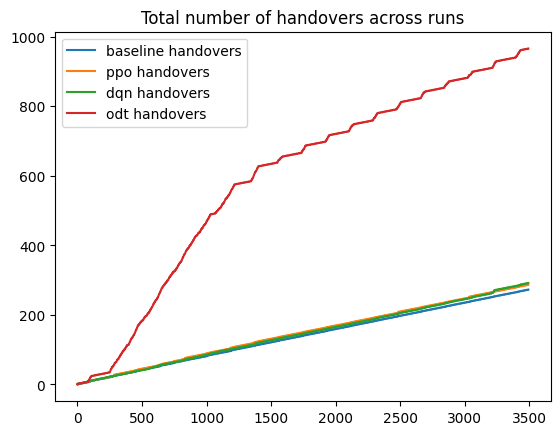

In [8]:
import matplotlib.pyplot as plt
plt.plot(obs_base_list[:, 6], label = 'baseline handovers')
plt.plot(obs_ppo_list[:, 6], label = 'ppo handovers')
plt.plot(obs_dqn_list[:, 6],  label = 'dqn handovers')
plt.plot(obs_odt_list[:, 6], label = 'odt handovers')
plt.legend()
#plt.yticks(np.arange(0, 200, step=10))
plt.title('Total number of handovers across runs')
plt.show()

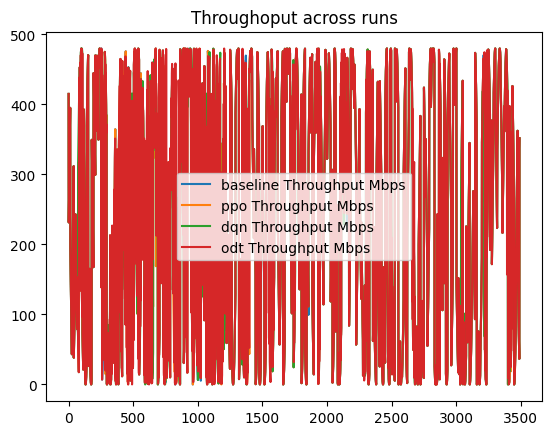

In [10]:
import matplotlib.pyplot as plt
plt.plot(obs_base_list[:, 13], label = 'baseline Throughput Mbps')
plt.plot(obs_ppo_list[:, 13], label = 'ppo Throughput Mbps')
plt.plot(obs_dqn_list[:, 13],  label = 'dqn Throughput Mbps')
plt.plot(obs_odt_list[:, 13], label = 'odt Throughput Mbps')
plt.legend()
#plt.yticks(np.arange(0, 200, step=10))
plt.title('Throughoput across runs')
plt.show()

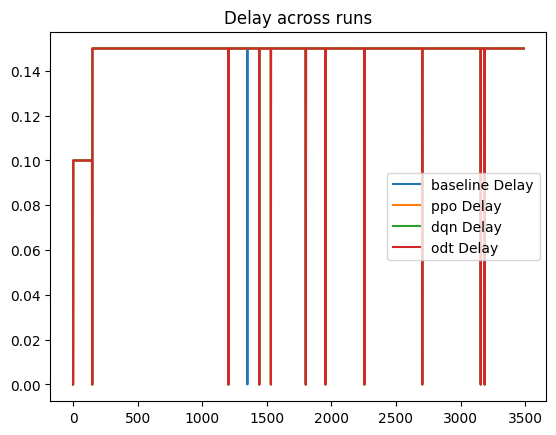

In [12]:
import matplotlib.pyplot as plt
plt.plot(obs_base_list[:, 14], label = 'baseline Delay')
plt.plot(obs_ppo_list[:, 14], label = 'ppo Delay')
plt.plot(obs_dqn_list[:, 14],  label = 'dqn Delay')
plt.plot(obs_odt_list[:, 14], label = 'odt Delay')
plt.legend()
#plt.yticks(np.arange(0, 200, step=10))
plt.title('Delay across runs')
plt.show()

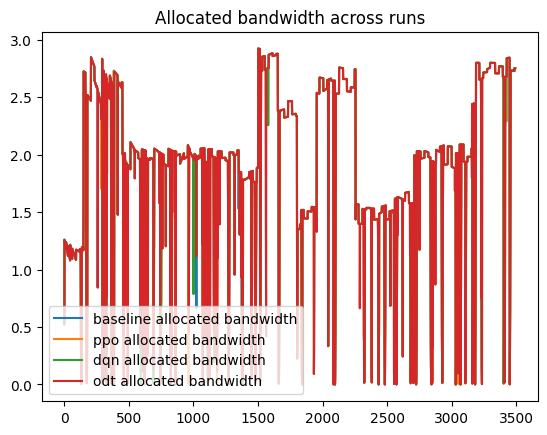

In [13]:
plt.plot(obs_base_list[:, 7], label = 'baseline allocated bandwidth')
plt.plot(obs_ppo_list[:, 7], label = 'ppo allocated bandwidth')
plt.plot(obs_dqn_list[:, 7], label = 'dqn allocated bandwidth')
plt.plot(obs_odt_list[:, 7], label = 'odt allocated bandwidth')
plt.legend()
plt.title('Allocated bandwidth across runs')
plt.show()

In [14]:
# Get average allocation to demand across runs 
avg_allocated_to_demand_base = []
avg_allocated_to_demand_ppo = []
avg_allocated_to_demand_dqn = []
avg_allocated_to_demand_odt = []

for i in range(len(obs_base_list)): 
    avg_allocated_to_demand_base.append(np.mean(obs_base_list[:i, 8]))
    avg_allocated_to_demand_ppo.append(np.mean(obs_ppo_list[:i, 8]))
    avg_allocated_to_demand_dqn.append(np.mean(obs_dqn_list[:i, 8]))
    avg_allocated_to_demand_odt.append(np.mean(obs_odt_list[:i, 8]))

/Users/hindmukhtar/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hindmukhtar/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


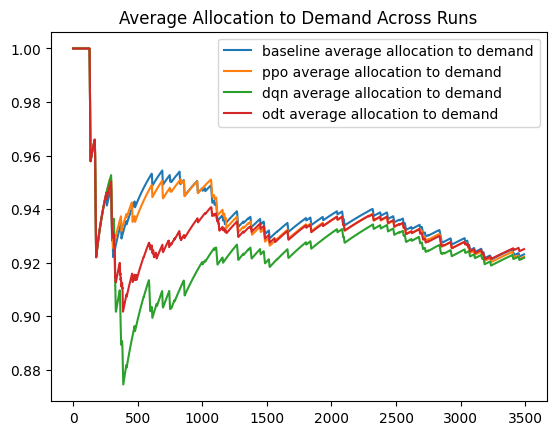

In [15]:
plt.plot(avg_allocated_to_demand_base, label = 'baseline average allocation to demand')
plt.plot(avg_allocated_to_demand_ppo, label = 'ppo average allocation to demand')
plt.plot(avg_allocated_to_demand_dqn, label = 'dqn average allocation to demand')
plt.plot(avg_allocated_to_demand_odt, label = 'odt average allocation to demand')
plt.legend()
plt.title('Average Allocation to Demand Across Runs')
plt.show()

In [16]:
# Average Allocation to demand 
print("Baseline Average Allocation to Demand: ", np.mean(obs_base_list[:, 8]))
print("PPO Average Allocation to Demand: ", np.mean(obs_ppo_list[:, 8]))
print("DQN Average Allocation to Demand: ", np.mean(obs_dqn_list[:, 8]))
print("ODT Average Allocation to Demand: ", np.mean(obs_odt_list[:, 8]))    


Baseline Average Allocation to Demand:  0.923130011265869
PPO Average Allocation to Demand:  0.9222190267522126
DQN Average Allocation to Demand:  0.9218273814180283
ODT Average Allocation to Demand:  0.9250865552050648


In [17]:
# Average throughput across runs
print("Baseline Average Throughput Mbps: ", np.mean(obs_base_list[:, 13]))
print("PPO Average Throughput Mbps: ", np.mean(obs_ppo_list[:, 13]))
print("DQN Average Throughput Mbps: ", np.mean(obs_dqn_list[:, 13]))
print("ODT Average Throughput Mbps: ", np.mean(obs_odt_list[:, 13]))

Baseline Average Throughput Mbps:  245.26466034232902
PPO Average Throughput Mbps:  243.24066775795944
DQN Average Throughput Mbps:  241.8294253889206
ODT Average Throughput Mbps:  247.8415964482515


In [18]:
# Average Delay across runs
print("Baseline Average Delay ms: ", np.mean(obs_base_list[:, 14]))
print("PPO Average Delay ms: ", np.mean(obs_ppo_list[:, 14]))
print("DQN Average Delay ms: ", np.mean(obs_dqn_list[:, 14]))
print("ODT Average Delay ms: ", np.mean(obs_odt_list[:, 14]))

Baseline Average Delay ms:  0.1473797308377076
PPO Average Delay ms:  0.1471792726403044
DQN Average Delay ms:  0.1471792726403044
ODT Average Delay ms:  0.1471792726403044


In [20]:
# Total Handovers 
print("Baseline Total Handovers: ", np.max(obs_base_list[:, 6]))
print("PPO Total Handovers: ", np.max(obs_ppo_list[:, 6]))
print("DQN Total Handovers: ", np.max(obs_dqn_list[:, 6]))
print("ODT Total Handovers: ", np.max(obs_odt_list[:, 6]))

Baseline Total Handovers:  273.0
PPO Total Handovers:  287.0
DQN Total Handovers:  292.0
ODT Total Handovers:  966.0
